feel free to make copies of this notebook so we can have multiple models training at the same time

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
# File manipulation and IO (input/output)
import os, shutil
import pickle
import zipfile
from google.colab import files

# Import numerical and dataframe handling
import numpy as np
import scipy
import pandas as pd

# Data preprocessing
from PIL import Image
from sklearn.utils import shuffle

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import sklearn

# Import standard machine learning machinery
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Garbage collection (for saving RAM during training)
import gc

# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib
import skimage.transform as transform

This loads all the X-Ray data into DirectoryIterator objects. Rudimentary data augmentation has already been performed on the training data

In [8]:
image_height = 299
image_width = 299
seed = 999

one_hot_to_string = [([1.,0.,0.,0.,0.],'NORMAL'),
                    ([0.,1.,0.,0.,0.],'COVID-19'),
                    ([0.,0.,1.,0.,0.],'BACTERIAL PNEUMONIA'),
                    ([0.,0.,0.,1.,0.],'VIRAL PNEUMONIA'),
                    ([0.,0.,0.,0.,1.],'TUBERCULOSIS')]

base_dir = '/content/gdrive/My Drive/covid project'
Xray_train_dir = os.path.join(base_dir, 'Xray_images_train_v2')
Xray_val_dir = os.path.join(base_dir, 'Xray_images_val_v2')
Xray_test_dir = os.path.join(base_dir, 'Xray_images_test_v2')


train_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=8,
                                                                width_shift_range=.15,
                                                                height_shift_range=.15,
                                                                horizontal_flip=True,
                                                                zoom_range=0.2,
                                                                samplewise_std_normalization=True)


val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                samplewise_std_normalization=True)

print('Xray image info (train, val, test):')
train_xray = train_augmented.flow_from_directory(Xray_train_dir, target_size=(image_height, image_width), color_mode='rgb', seed=seed)
val_xray = val_generator.flow_from_directory(Xray_val_dir, target_size=(image_height, image_width), color_mode='rgb', seed=seed)
test_xray = val_generator.flow_from_directory(Xray_test_dir, target_size=(image_height, image_width), color_mode='rgb', seed=seed)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Xray image info (train, val, test):
Found 6324 images belonging to 5 classes.
Found 1574 images belonging to 5 classes.
Found 1970 images belonging to 5 classes.


Load a few images from the validation set. (note: this might change the order of the samples called from the generator, so before you run any models feel free to re-initialize the data)

In [9]:
'''samples, labels = next(val_xray)

five_samples = samples[:5]
five_labels = labels[:5]

fig, axes=plt.subplots(1,5,figsize=(20,20))
axes=axes.flatten()
for num, (img, ax) in enumerate(zip(five_samples, axes)):
  ax.imshow(img)
  one_hot = five_labels[num]
  ax.set_xlabel([y for x,y in one_hot_to_string if x == list(one_hot)])
plt.tight_layout()
plt.show()'''

'samples, labels = next(val_xray)\n\nfive_samples = samples[:5]\nfive_labels = labels[:5]\n\nfig, axes=plt.subplots(1,5,figsize=(20,20))\naxes=axes.flatten()\nfor num, (img, ax) in enumerate(zip(five_samples, axes)):\n  ax.imshow(img)\n  one_hot = five_labels[num]\n  ax.set_xlabel([y for x,y in one_hot_to_string if x == list(one_hot)])\nplt.tight_layout()\nplt.show()'

In [10]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.DenseNet201(input_shape=(image_height, image_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = Flatten()
dense_layer1 = tf.keras.layers.Dense(32, activation='relu')
dense_layer2 = tf.keras.layers.Dense(5, activation='softmax')

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    flatten_layer,
    dense_layer1,
    dense_layer2
])
#, loss_weights=[1, 6, 1, 1, 6])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC', tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), 'accuracy'], run_eagerly=True)


model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 9, 9, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                61472     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 18,383,621
Trainable params: 61,637
Non-trainable params: 18,321,984
_________________________________________________________________


In [11]:
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

class_weight = {0: 1.,
                1: 6.,
                2: 1.,
                3: 1.,
                4: 6.}

history = model.fit(train_xray,
                    epochs=50,
                    batch_size=5,
                    callbacks=[garbage_collect_callback(), early_stop],
                    validation_data=val_xray,
                    verbose=1,
                    class_weight=class_weight)

Epoch 1/50
198/198 [==============================] - 3261s 16s/step - loss: 1.4438 - auc: 0.8672 - true_negatives: 12310.2211 - false_positives: 448.8543 - true_positives: 1448.3920 - false_negatives: 1741.3769 - accuracy: 0.6083 - val_loss: 0.6726 - val_auc: 0.9414 - val_true_negatives: 6003.0000 - val_false_positives: 293.0000 - val_true_positives: 1050.0000 - val_false_negatives: 524.0000 - val_accuracy: 0.7332
Epoch 2/50
198/198 [==============================] - 384s 2s/step - loss: 0.7635 - auc: 0.9479 - true_negatives: 12147.4724 - false_positives: 614.0151 - true_positives: 2201.2965 - false_negatives: 989.0754 - accuracy: 0.7452 - val_loss: 0.6401 - val_auc: 0.9463 - val_true_negatives: 5999.0000 - val_false_positives: 297.0000 - val_true_positives: 1083.0000 - val_false_negatives: 491.0000 - val_accuracy: 0.7427
Epoch 3/50
198/198 [==============================] - 381s 2s/step - loss: 0.7105 - auc: 0.9554 - true_negatives: 12155.7940 - false_positives: 605.4523 - true_posit

In [12]:
model.save('final_model.h5')

In [13]:
test_xray.shuffle = False
test_xray.reset()

predictions = model.predict(test_xray)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_xray.classes
class_labels = list(test_xray.class_indices.keys())   

This cell calculates the test accuracy


In [14]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
acc = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
print(f' Model Accuracy: {acc:.2%}')


                         precision    recall  f1-score   support

             1 - NORMAL       0.84      0.93      0.88       639
           2 - COVID-19       0.97      0.98      0.97       125
3 - BACTERIAL PNEUMONIA       0.74      0.77      0.75       556
    4 - VIRAL PNEUMONIA       0.80      0.63      0.70       567
       5 - TUBERCULOSIS       0.66      0.94      0.77        83

               accuracy                           0.80      1970
              macro avg       0.80      0.85      0.82      1970
           weighted avg       0.80      0.80      0.80      1970

 Model Accuracy: 79.95%


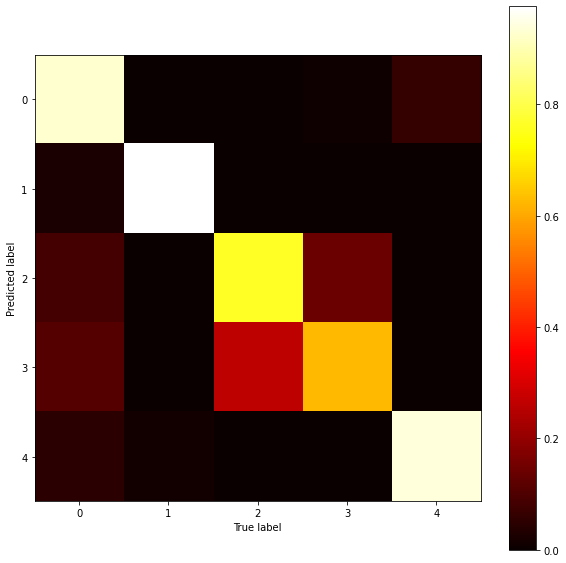

[[594   0   0   6  39]
 [  3 122   0   0   0]
 [ 47   1 426  80   2]
 [ 61   2 149 355   0]
 [  4   1   0   0  78]]


In [15]:
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
plt.imshow(confusion_matrix(true_classes, predicted_classes, normalize='true'), cmap='hot', interpolation='nearest')

# Add some anotation for the plot
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()
print(conf_mat)

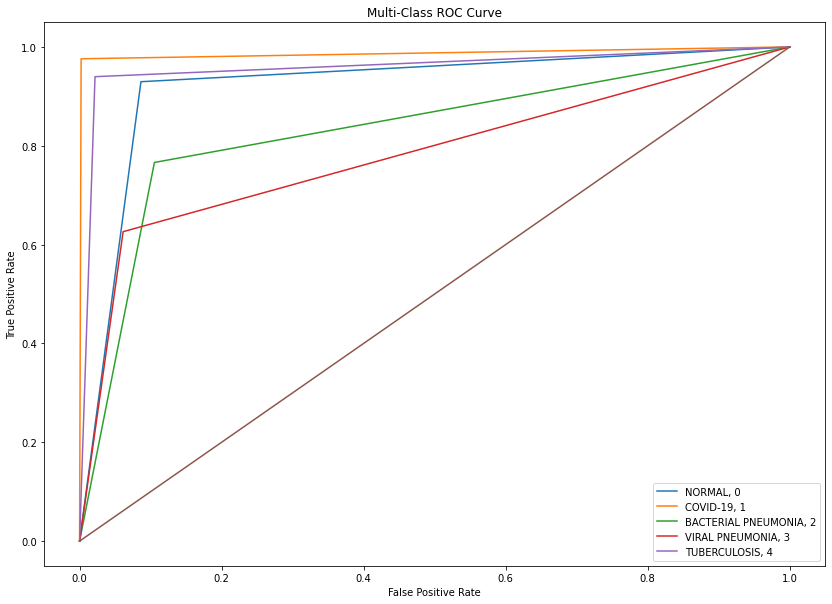

In [16]:
#This cell will print a ROC curve for prediction data. Have 

from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

fpr = {}
tpr = {}
roc_auc = {}

#Initalize key reference dictionaries 
stage_dict = {0:'NORMAL', 1:'COVID-19', 2:'BACTERIAL PNEUMONIA', 3:'VIRAL PNEUMONIA', 4:'TUBERCULOSIS'}

#Convert ndarray prediction and true labels to pandas dataframes, and then perform one hot encoding
'''
true_classes: ndarray containing true labels
predicted_classes: ndarray containing predicted labels
'''
true_classes_df = pd.DataFrame(true_classes)
true_classes_df = pd.get_dummies(true_classes_df[0], prefix='disease')
predicted_classes_df = pd.DataFrame(predicted_classes)
predicted_classes_df = pd.get_dummies(predicted_classes_df[0], prefix='disease')

#Plot roc curves
plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(true_classes_df.iloc[:, i], predicted_classes_df.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(true_classes_df.values.ravel(), predicted_classes_df.values.ravel())

roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])
print("Averge AUC:")
print(roc_auc_agg)

In [17]:
'''val_xray.shuffle = False
val_xray.reset()

predictions = model.predict(val_xray)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = val_xray.classes
class_labels = list(val_xray.class_indices.keys())   '''

'val_xray.shuffle = False\nval_xray.reset()\n\npredictions = model.predict(val_xray)\n# Get most likely class\npredicted_classes = np.argmax(predictions, axis=1)\n\ntrue_classes = val_xray.classes\nclass_labels = list(val_xray.class_indices.keys())   '

Averge AUC:
0.8746827411167513


In [18]:
'''report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
acc = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
print(f' Model Accuracy: {acc:.2%}')'''


"report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)\nprint(report)\nacc = sklearn.metrics.accuracy_score(true_classes, predicted_classes)\nprint(f' Model Accuracy: {acc:.2%}')"

In [19]:
'''conf_mat = confusion_matrix(true_classes, predicted_classes)

# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
plt.imshow(confusion_matrix(true_classes, predicted_classes, normalize='true'), cmap='hot', interpolation='nearest')

# Add some anotation for the plot
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()
print(conf_mat)
'''

"conf_mat = confusion_matrix(true_classes, predicted_classes)\n\n# Generate a new figure\nplt.figure(figsize=(10,10))\n\n# Display the confusion matrix\nplt.imshow(confusion_matrix(true_classes, predicted_classes, normalize='true'), cmap='hot', interpolation='nearest')\n\n# Add some anotation for the plot\nplt.colorbar()\nplt.xlabel('True label')\nplt.ylabel('Predicted label')\nplt.show()\nprint(conf_mat)\n"

In [1]:
#This cell will print a ROC curve for prediction data. Have 
'''
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

fpr = {}
tpr = {}
roc_auc = {}

#Initalize key reference dictionaries 
stage_dict = {0:'NORMAL', 1:'COVID-19', 2:'BACTERIAL PNEUMONIA', 3:'VIRAL PNEUMONIA', 4:'TUBERCULOSIS'}

#Convert ndarray prediction and true labels to pandas dataframes, and then perform one hot encoding

#true_classes: ndarray containing true labels
#predicted_classes: ndarray containing predicted labels

true_classes_df = pd.DataFrame(true_classes)
true_classes_df = pd.get_dummies(true_classes_df[0], prefix='disease')
predicted_classes_df = pd.DataFrame(predicted_classes)
predicted_classes_df = pd.get_dummies(predicted_classes_df[0], prefix='disease')

#Plot roc curves
plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(true_classes_df.iloc[:, i], predicted_classes_df.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(true_classes_df.values.ravel(), predicted_classes_df.values.ravel())

roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])
print("Averge AUC:")
print(roc_auc_agg)'''

SyntaxError: ignored